In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

In [52]:
import os
import pandas as pd
import numpy as np

data_dir = '/teamspace/studios/this_studio'
experiment_dir = 'outputs/crim13/hand=500_pseudo=1000'
video_names = ['030609_A25_Block11_BCfe1_t', '030609_A25_Block16_castBCma1_t','030809_A29_Block5_castBCma1_t',
                    '031309_A29_Block12_castBCma2_t','031309_A29_Block14_BCfe1_t','031909_A29_Block17_BCfe1_t',
                    '032509_A29_Block13_BCfe1_t','032509_A29_Block16_ovtBCfe1_t','032909_A29_Block14_ovtBCfe1_t',
                    '032909_A29_Block15_castBCma1_t','033109_A25_Block5_BCfe1_t','']  
file_paths_template = os.path.join(data_dir, experiment_dir, 'networks', 'rng{rng_idx}', 'video_preds', '{video_name}.csv')
review_dir = os.path.join(data_dir, experiment_dir, 'review_frames')
os.makedirs(review_dir, exist_ok=True)

def process_and_save_csv(file_paths, output_file_path):
    merged_data = None

    for idx, video_file_path in enumerate(file_paths):
        rng_identifier = f"rng{idx}"
        print(f"Processing file: {video_file_path} with identifier: {rng_identifier}")
        data = pd.read_csv(video_file_path)
        data_transformed = []

        # Extract video name from file_path
        video_name = os.path.basename(video_file_path).split('.')[0]

        body_parts = data.iloc[0, 1::3].tolist()

        for i in range(2, len(data)):
            image_path = data.iloc[i, 0]
            # Prepend video name to image_path
            full_image_path = f"{video_name}/{image_path}"
            for j, part in enumerate(body_parts):
                x_index = 1 + j * 3
                y_index = 2 + j * 3
                likelihood_index = 3 + j * 3

                if all(index < len(data.columns) for index in [x_index, y_index, likelihood_index]):
                    x, y, likelihood = data.iloc[i, [x_index, y_index, likelihood_index]]
                    data_transformed.append([full_image_path, part, x, y, likelihood])

        transformed_df = pd.DataFrame(data_transformed, columns=["image_path", "body_part", f"x_{rng_identifier}", f"y_{rng_identifier}", f"likelihood_{rng_identifier}"])

        if merged_data is None:
            merged_data = transformed_df
        else:
            merged_data = pd.merge(merged_data, transformed_df, on=["image_path", "body_part"])

    print("Columns in merged_data after merging all files:", merged_data.columns.tolist())

    x_columns = [col for col in merged_data.columns if col.startswith('x_')]
    y_columns = [col for col in merged_data.columns if col.startswith('y_')]
    likelihood_columns = [col for col in merged_data.columns if col.startswith('likelihood_')]

    if len(x_columns) == 0 or len(y_columns) == 0:
        print("No x or y columns found after merging. Please check your file paths and identifiers.")
        return

    merged_data['ensemble_mean_x'] = merged_data[x_columns].astype(float).mean(axis=1)
    merged_data['ensemble_mean_y'] = merged_data[y_columns].astype(float).mean(axis=1)

    merged_data['ensemble_median_x'] = merged_data[x_columns].astype(float).median(axis=1)
    merged_data['ensemble_median_y'] = merged_data[y_columns].astype(float).median(axis=1)

    merged_data['ensemble_variance_x'] = merged_data[x_columns].astype(float).var(axis=1)
    merged_data['ensemble_variance_y'] = merged_data[y_columns].astype(float).var(axis=1)

    merged_data['ensemble_variance'] = merged_data['ensemble_variance_x'] + merged_data['ensemble_variance_y']
    merged_data['ensemble_std'] = np.sqrt(merged_data['ensemble_variance'])

    merged_data['num_likelihood_above_0.9'] = merged_data[likelihood_columns].astype(float).gt(0.9).sum(axis=1)

    std_bins = [0, 5, 10, 15, 20, float('inf')]
    std_labels = ['0-5', '5-10', '10-15', '15-20', '20+']
    merged_data['ensemble_std_bin'] = pd.cut(merged_data['ensemble_std'], bins=std_bins, labels=std_labels, include_lowest=True)

    merged_data['ensemble_variance_log'] = np.log1p(merged_data['ensemble_variance'])
    merged_data['ensemble_variance_log_bin'] = pd.cut(merged_data['ensemble_variance_log'], bins=10, labels=False)
    log_bins = pd.cut(merged_data['ensemble_variance_log'], bins=10)
    merged_data['ensemble_variance_log_bin_label'] = log_bins.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')
    ensemble_variance_bins_labels = pd.cut(merged_data['ensemble_variance'], bins=10)
    merged_data['ensemble_variance_bin_label'] = ensemble_variance_bins_labels.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')

    merged_data.to_csv(output_file_path, index=False)
    print(f"Concatenated data saved to {output_file_path}")

def process_all_videos(video_names):
    intermediate_files = []

    for video_name in video_names:
        file_paths = [
            file_paths_template.format(rng_idx=i, video_name=video_name)
            for i in range(5)
        ]
        output_file_path = os.path.join(review_dir, f'histogram_{video_name}.csv')
        process_and_save_csv(file_paths, output_file_path)
        intermediate_files.append(output_file_path)

    # Read each intermediate CSV file into a DataFrame and concatenate them
    all_data_frames = [pd.read_csv(file) for file in intermediate_files]
    concatenated_data = pd.concat(all_data_frames, ignore_index=True)
    
    # Save the final concatenated result to a new CSV file
    final_output_file_path = os.path.join(review_dir, 'histogram_all.csv')
    concatenated_data.to_csv(final_output_file_path, index=False)
    print(f"All concatenated data saved to {final_output_file_path}")

process_all_videos(video_names)


Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0/video_preds/test_vid.csv with identifier: rng0
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1/video_preds/test_vid.csv with identifier: rng1
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds/test_vid.csv with identifier: rng2
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng3/video_preds/test_vid.csv with identifier: rng3
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng4/video_preds/test_vid.csv with identifier: rng4
Columns in merged_data after merging all files: ['image_path', 'body_part', 'x_rng0', 'y_rng0', 'likelihood_rng0', 'x_rng1', 'y_rng1', 'likelihood_rng1', 'x_rng2', 'y_rng2', 'likelihood_rng2', 'x_rng3', 'y_rng3', 'likelihood_rng3', 'x_rng4', 'y_

Total number of frames: 994


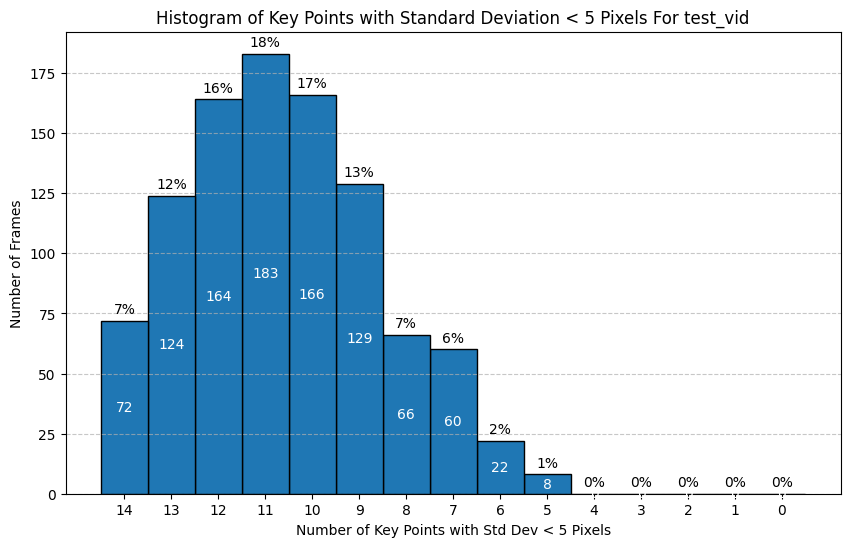

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new CSV file
new_file_path = '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/histogram_test_vid.csv'
new_data_file = pd.read_csv(new_file_path)

# Extract the specified columns from the new dataframe
new_data_extracted = new_data_file[['image_path', 'body_part', 'ensemble_variance', 'ensemble_std']]

# Filter data to count body parts with standard deviation less than 5 pixels for each image path
filtered_new_data = new_data_extracted[new_data_extracted['ensemble_std'] < 5]

# Count the number of body parts for each image path
count_body_parts_per_image_new = filtered_new_data.groupby('image_path').size()

# Create the histogram with annotations (rounded percentages and actual counts)
# Create the histogram with annotations (rounded percentages and actual counts within the bar)
plt.figure(figsize=(10, 6))
bars = plt.hist(count_body_parts_per_image_new, bins=range(count_body_parts_per_image_new.max() + 2), align='left', edgecolor='black')

# Annotate each bar with the rounded percentage of total frames and actual count
total_frames_new = count_body_parts_per_image_new.size
for bar, count in zip(bars[2], bars[0]):
    height = bar.get_height()
    percentage = round((height / total_frames_new) * 100)
    plt.annotate(f'{percentage}%', xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height / 2), 
                 xytext=(0, 0), textcoords='offset points', ha='center', va='center', color='white')

# Print the total number of frames
print("Total number of frames:", total_frames_new)

plt.xlabel('Number of Key Points with Std Dev < 5 Pixels')
plt.ylabel('Number of Frames')
plt.title('Histogram of Key Points with Standard Deviation < 5 Pixels For test_vid')
plt.xticks(range(count_body_parts_per_image_new.max() + 1)[::-1])  # Reverse the x-axis
plt.gca().invert_xaxis()  # Invert the x-axis direction
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [4]:
import os
import pandas as pd
import numpy as np

data_dir = '/teamspace/studios/this_studio'
experiment_dir = 'outputs/mirror-mouse/hand=100_pseudo=1000_old'
videos_dir = os.path.join(data_dir, 'data/mirror-mouse/videos_test')
videos_new_dir = os.path.join(data_dir, 'data/mirror-mouse/videos_test_new')

# Function to extract video names from a given directory
def extract_video_names_from_directory(directory):
    video_names = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.mp4'):
            video_name = os.path.splitext(file_name)[0]
            video_names.append(video_name)
    return video_names

# Extract video names from both directories
video_names = extract_video_names_from_directory(videos_dir) + extract_video_names_from_directory(videos_new_dir)

# Remove duplicates if any
video_names = list(set(video_names))

file_paths_template = os.path.join(data_dir, experiment_dir, 'networks', 'rng{rng_idx}', 'video_preds', '{video_name}.csv')
review_dir = os.path.join(data_dir, experiment_dir, 'review_frames')
os.makedirs(review_dir, exist_ok=True)

def process_and_save_csv(file_paths, output_file_path):
    merged_data = None

    for idx, video_file_path in enumerate(file_paths):
        rng_identifier = f"rng{idx}"
        print(f"Processing file: {video_file_path} with identifier: {rng_identifier}")
        data = pd.read_csv(video_file_path)
        data_transformed = []

        # Extract video name from file_path
        video_name = os.path.basename(video_file_path).split('.')[0]

        body_parts = data.iloc[0, 1::3].tolist()

        for i in range(2, len(data)):
            image_path = data.iloc[i, 0]
            # Prepend video name to image_path
            full_image_path = f"{video_name}/{image_path}"
            for j, part in enumerate(body_parts):
                x_index = 1 + j * 3
                y_index = 2 + j * 3
                likelihood_index = 3 + j * 3

                if all(index < len(data.columns) for index in [x_index, y_index, likelihood_index]):
                    x, y, likelihood = data.iloc[i, [x_index, y_index, likelihood_index]]
                    data_transformed.append([full_image_path, part, x, y, likelihood])

        transformed_df = pd.DataFrame(data_transformed, columns=["image_path", "body_part", f"x_{rng_identifier}", f"y_{rng_identifier}", f"likelihood_{rng_identifier}"])

        if merged_data is None:
            merged_data = transformed_df
        else:
            merged_data = pd.merge(merged_data, transformed_df, on=["image_path", "body_part"])

    print("Columns in merged_data after merging all files:", merged_data.columns.tolist())

    x_columns = [col for col in merged_data.columns if col.startswith('x_')]
    y_columns = [col for col in merged_data.columns if col.startswith('y_')]
    likelihood_columns = [col for col in merged_data.columns if col.startswith('likelihood_')]

    if len(x_columns) == 0 or len(y_columns) == 0:
        print("No x or y columns found after merging. Please check your file paths and identifiers.")
        return

    merged_data['ensemble_mean_x'] = merged_data[x_columns].astype(float).mean(axis=1)
    merged_data['ensemble_mean_y'] = merged_data[y_columns].astype(float).mean(axis=1)

    merged_data['ensemble_median_x'] = merged_data[x_columns].astype(float).median(axis=1)
    merged_data['ensemble_median_y'] = merged_data[y_columns].astype(float).median(axis=1)

    merged_data['ensemble_variance_x'] = merged_data[x_columns].astype(float).var(axis=1)
    merged_data['ensemble_variance_y'] = merged_data[y_columns].astype(float).var(axis=1)

    merged_data['ensemble_variance'] = merged_data['ensemble_variance_x'] + merged_data['ensemble_variance_y']
    merged_data['ensemble_std'] = np.sqrt(merged_data['ensemble_variance'])

    merged_data['num_likelihood_above_0.9'] = merged_data[likelihood_columns].astype(float).gt(0.9).sum(axis=1)

    std_bins = [0, 5, 10, 15, 20, float('inf')]
    std_labels = ['0-5', '5-10', '10-15', '15-20', '20+']
    merged_data['ensemble_std_bin'] = pd.cut(merged_data['ensemble_std'], bins=std_bins, labels=std_labels, include_lowest=True)

    merged_data['ensemble_variance_log'] = np.log1p(merged_data['ensemble_variance'])
    merged_data['ensemble_variance_log_bin'] = pd.cut(merged_data['ensemble_variance_log'], bins=10, labels=False)
    log_bins = pd.cut(merged_data['ensemble_variance_log'], bins=10)
    merged_data['ensemble_variance_log_bin_label'] = log_bins.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')
    ensemble_variance_bins_labels = pd.cut(merged_data['ensemble_variance'], bins=10)
    merged_data['ensemble_variance_bin_label'] = ensemble_variance_bins_labels.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')

    merged_data.to_csv(output_file_path, index=False)
    print(f"Concatenated data saved to {output_file_path}")

def process_all_videos(video_names):
    intermediate_files = []

    for video_name in video_names:
        file_paths = [
            file_paths_template.format(rng_idx=i, video_name=video_name)
            for i in range(5)
        ]
        output_file_path = os.path.join(review_dir, f'histogram_{video_name}.csv')
        process_and_save_csv(file_paths, output_file_path)
        intermediate_files.append(output_file_path)

    # Read each intermediate CSV file into a DataFrame and concatenate them
    all_data_frames = [pd.read_csv(file) for file in intermediate_files]
    concatenated_data = pd.concat(all_data_frames, ignore_index=True)
    
    # Save the final concatenated result to a new CSV file
    final_output_file_path = os.path.join(review_dir, 'histogram_all.csv')
    concatenated_data.to_csv(final_output_file_path, index=False)
    print(f"All concatenated data saved to {final_output_file_path}")

process_all_videos(video_names)


Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000_old/networks/rng0/video_preds/clip_0.csv with identifier: rng0
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000_old/networks/rng1/video_preds/clip_0.csv with identifier: rng1
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000_old/networks/rng2/video_preds/clip_0.csv with identifier: rng2
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000_old/networks/rng3/video_preds/clip_0.csv with identifier: rng3
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000_old/networks/rng4/video_preds/clip_0.csv with identifier: rng4
Columns in merged_data after merging all files: ['image_path', 'body_part', 'x_rng0', 'y_rng0', 'likelihood_rng0', 'x_rng1', 'y_rng1', 'likelihood_rng1', 'x_rng2', 'y_rng2', 'likelihood_rng2', 'x_rng3', 'y_rng3', 'likelihood_rng3', 'x_

Total number of frames: 15994


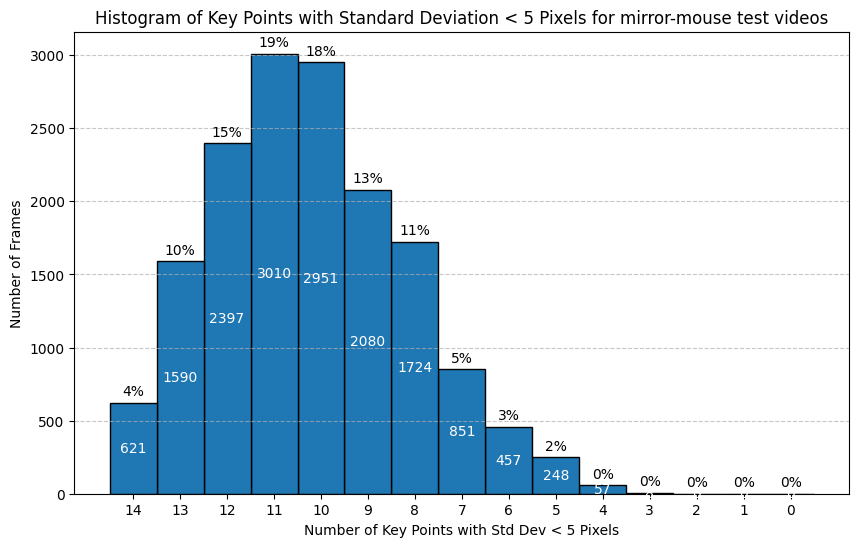

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new CSV file
new_file_path = '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/histogram_clip_0.csv'
new_data_file = pd.read_csv(new_file_path)

# Extract the specified columns from the new dataframe
new_data_extracted = new_data_file[['image_path', 'body_part', 'ensemble_variance', 'ensemble_std']]

# Filter data to count body parts with standard deviation less than 5 pixels for each image path
filtered_new_data = new_data_extracted[new_data_extracted['ensemble_std'] < 5]

# Count the number of body parts for each image path
count_body_parts_per_image_new = filtered_new_data.groupby('image_path').size()

# Create the histogram with annotations (rounded percentages and actual counts)
# Create the histogram with annotations (rounded percentages and actual counts within the bar)
plt.figure(figsize=(10, 6))
bars = plt.hist(count_body_parts_per_image_new, bins=range(count_body_parts_per_image_new.max() + 2), align='left', edgecolor='black')

# Annotate each bar with the rounded percentage of total frames and actual count
total_frames_new = count_body_parts_per_image_new.size
for bar, count in zip(bars[2], bars[0]):
    height = bar.get_height()
    percentage = round((height / total_frames_new) * 100)
    plt.annotate(f'{percentage}%', xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height / 2), 
                 xytext=(0, 0), textcoords='offset points', ha='center', va='center', color='white')

# Print the total number of frames
print("Total number of frames:", total_frames_new)

plt.xlabel('Number of Key Points with Std Dev < 5 Pixels')
plt.ylabel('Number of Frames')
plt.title('Histogram of Key Points with Standard Deviation < 5 Pixels for mirror-mouse test videos')
plt.xticks(range(count_body_parts_per_image_new.max() + 1)[::-1])  # Reverse the x-axis
plt.gca().invert_xaxis()  # Invert the x-axis direction
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [3]:
import pandas as pd
# Load the new CSV file
new_file_path = '/teamspace/studios/this_studio/outputs/crim13/hand=500_pseudo=1000/review_frames/histogram_all.csv'
new_data_file = pd.read_csv(new_file_path)

# Extract the specified columns from the new dataframe
new_data_extracted = new_data_file[['image_path', 'body_part', 'ensemble_variance', 'ensemble_std']]

# Filter data to count body parts with standard deviation less than 5 pixels for each image path
filtered_new_data = new_data_extracted[new_data_extracted['ensemble_std'] < 10]

# Count the number of body parts for each image path
count_body_parts_per_image_new = filtered_new_data.groupby('image_path').size()

# Annotate each bar with the rounded percentage of total frames and actual count
total_frames_new = count_body_parts_per_image_new.size
